### Define the model architecture using a self-attention transformer
2. Deep Learning Models: VAE, Diffusion Model, Self-attention, and Transformer

### Import libraries


In [24]:
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from tqdm import tqdm
from torch import Tensor
import math
import matplotlib.pyplot as plt

In [25]:
# # define the diffusion model
# class DiffusionModel(nn.Module):
#     def __init__(self, n_steps, n_heads, n_dims, n_hidden, output_dim, input_dim):
#         super().__init__()

#         self.n_steps = n_steps
#         self.n_heads = n_heads
#         self.n_dims = n_dims
#         self.n_hidden = n_hidden
#         self.empbed = nn.Linear(input_dim, n_dims)
#         self.transformer_layers = nn.ModuleList([
#             nn.TransformerEncoderLayer(n_dims, n_heads, n_hidden) 
#             for _ in range(n_steps)
#         ])

#         self.to_params = nn.Linear(n_dims, 2 * n_dims)
#         self.to_output = nn.Linear(n_dims, output_dim)

#     def sample_noise(self, batch_size, device):
#         return torch.randn(batch_size, self.n_dims, device=device)

#     def forward(self, x, timesteps_left):
#         x = self.empbed(x)
#         timesteps_left = timesteps_left.transpose(0, 1)
#         # apply the diffusion process
#         for i in reversed(range(self.n_steps)):
#             # sample noise for this step
#             noise = self.sample_noise(x.shape[0], x.device)

#             # get the parameters for this step
#             params = self.to_params(x)
#             mean, log_std = params.chunk(2, dim=-1)

#             # calculate the new state
#             std = torch.exp(log_std)
#             state = (x - mean) / std
#             state = state + noise * std
#             state = self.transformer_layers[i](state.unsqueeze(0)).squeeze(0)

#             # update x with the new state
#             x = mean + state * std
#             # apply the schedule
#             x = x * (1 - timesteps_left[i].unsqueeze(-1)) + noise * timesteps_left[i].sqrt().unsqueeze(-1)
#         # map the final state to RGB values
#         output = self.to_output(x)
#         return output

In [67]:
# Define the model architecture
class DiffusionModel(nn.Module):
    def __init__(self, num_channels=32, num_steps=10, input_dim=5, nhead=1, dropout=0.1, num_layers=4):
        super(DiffusionModel, self).__init__()
        self.num_channels = num_channels
        self.num_steps = num_steps
        self.net = nn.Sequential(
            nn.Linear(5, num_channels),
            nn.ReLU(),
            nn.Linear(num_channels, num_channels),
            nn.ReLU(),
            nn.Linear(num_channels, num_channels),
            nn.ReLU(),
            nn.Linear(num_channels, 5)
        )
        # self.net = nn.TransformerEncoder(
        #     nn.TransformerEncoderLayer(
        #         input_dim, 
        #         nhead=nhead, 
        #         dim_feedforward=input_dim, 
        #         dropout=dropout), 
        #     num_layers=num_layers)
    def forward(self, x, t):

        for i in range(self.num_steps):
            # Apply reverse diffusion step
            noise = torch.randn_like(x)
            noise = noise * (1 - (t / self.num_steps)).sqrt().unsqueeze(-1)
            y = x + noise
            x = self.net(y)
        return x

Epoch [100/100], Train Loss: 0.0336: 100%|██████████| 100/100 [03:56<00:00,  2.37s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


xy mean: 146.68803609181674, xy std: 2.0169212208210583, xy max: 159.77215576171875, xy min: 136.51287841796875
rgb mean: 149.7315474646723, rgb std: 16.845471569813835, rgb max: 187.5168914794922, rgb min: 126.75244903564453
Error: 11.332996296296296


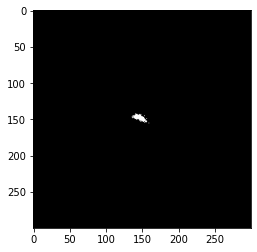

In [68]:
class ColoredPiDataset(Dataset):
    def __init__(self, image_path, xs_path, ys_path):
        self.xs = np.load(xs_path)
        self.ys = np.load(ys_path)
        self.image_array = np.array(Image.open(image_path))
        self.rgb_values = self.image_array[self.xs, self.ys]
        
        # # Normalize xy values to be between 0 and 1
        self.xs, self.ys = self.xs / 299.0, self.ys / 299.0

        # # Normalize rgb values to be between 0 and 1
        self.rgb_values = self.rgb_values / 255.0

        # Normalize xy values to be between -1 and 1
        # self.xs, self.ys = (self.xs / 149.5) - 1.0, (self.ys / 149.5) - 1.0
        
        # # Normalize rgb values to be between -1 and 1
        # self.rgb_values = (self.rgb_values / 127.5) - 1.0

    def __len__(self):
        return len(self.xs)
        # return 30000

    def __getitem__(self, idx):
        if idx >= 5000:
            return torch.zeros((5)).to(torch.float32)
        return torch.tensor([self.xs[idx], self.ys[idx], self.rgb_values[idx][0], self.rgb_values[idx][1], self.rgb_values[idx][2]]).to(torch.float32)

# Define training function
def train_diffusion(model, optimizer, criterion, dataloader, device):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        noise = torch.randn(batch.shape[0], 128).to(device)
        
        # # generate the timesteps_left schedule
        # timesteps_left = torch.linspace(0, 1, model.n_steps, device=device)
        # timesteps_left = timesteps_left.expand(batch_size, -1)
        # # generate the RGB values using the model
        # outputs = model(batch, timesteps_left)
        
        batch_t = np.random.randint(0, model.num_steps, size=batch_size)
        batch_t = np.sort(batch_t)[::-1] # Reverse order
        batch_t = torch.FloatTensor(batch_t / model.num_steps).to(device)
        outputs = model(batch, batch_t)

        loss = criterion(outputs, batch)

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameters
input_dim = 5 # XYRGB values
output_dim = 5 # XYRGB values
hidden_dim = 128
latent_dim = 16
num_layers = 2
num_heads = 4
dropout = 0.1

batch_size = 32
learning_rate = 3e-4
num_epochs = 100
num_samples = 500

# Load the dataset
dataset = ColoredPiDataset('sparse_pi_colored.jpg', 'pi_xs.npy', 'pi_ys.npy')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Initialize model, optimizer, and loss function
# model = DiffusionModel(n_steps=100, n_heads=4, n_dims=128, n_hidden=512, output_dim=output_dim, input_dim=input_dim).to(device)
model = DiffusionModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Train model
iteration = tqdm(range(num_epochs))
for epoch in iteration:
    train_loss = train_diffusion(model, optimizer, criterion, dataloader, device)
    iteration.set_description('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))
    
# Generate some samples from the model
generated_image = np.zeros(dataset.image_array.shape)

xy  = np.zeros((len(dataloader)*batch_size, 2))
rgb = np.zeros((len(dataloader)*batch_size, 3))
for sample_idx, batch in enumerate(dataloader):
    with torch.no_grad():
        samples = model.net(torch.randn(batch_size, 5).to(device))
        # samples = model.net(batch.to(device))

        # Denomarlizing samples
        # samples[:, :2] = (samples[:, :2] + 1) * 149.5
        samples[:, :2] = (samples[:, :2]) * 299
        
        # Denomarlizing samples
        # samples[:, 2:] = (samples[:, 2:] + 1) * 127.5
        samples[:, 2:] = (samples[:, 2:]) * 255
        
        xy[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, :2].cpu().numpy()
        rgb[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, 2:].cpu().numpy()

        samples = samples.cpu().numpy().astype(np.uint8)
        for i in range(batch_size):
            x, y, r, g, b = samples[i]
            generated_image[x, y] = [r, g, b]
            
print(f'xy mean: {np.mean(xy)}, xy std: {np.std(xy)}, xy max: {np.max(xy)}, xy min: {np.min(xy)}')
print(f'rgb mean: {np.mean(rgb)}, rgb std: {np.std(rgb)}, rgb max: {np.max(rgb)}, rgb min: {np.min(rgb)}')
print(f'Error: {np.mean(np.abs(generated_image - dataset.image_array))}')

# Save the output image
# Image.fromarray(generated_image).save('generated_pi_colored.jpg')
plt.imshow(generated_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


xy mean: 146.60585623673904, xy std: 1.985959831085107, xy max: 158.5348663330078, xy min: 136.91275024414062
rgb mean: 149.6209144847006, rgb std: 16.84920741350473, rgb max: 186.79725646972656, rgb min: 127.51536560058594
Error: 11.391051851851852


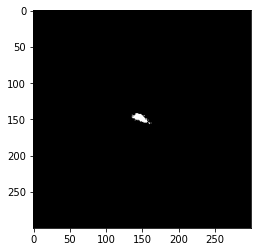

In [72]:
xy  = np.zeros((len(dataloader)*batch_size, 2))
rgb = np.zeros((len(dataloader)*batch_size, 3))
for sample_idx, batch in enumerate(dataloader):
    with torch.no_grad():
        # samples = model.net(torch.randn(batch_size, 5).to(device).unsqueeze(0)).squeeze(0)
        samples = model.net(torch.randn(batch_size, 5).to(device))
        # samples = model.net(batch.to(device).unsqueeze(0)).squeeze(0)
        # samples = model.net(batch.to(device))

        # Denomarlizing samples
        # samples[:, :2] = (samples[:, :2] + 1) * 149.5
        samples[:, :2] = (samples[:, :2]) * 299
        
        # Denomarlizing samples
        # samples[:, 2:] = (samples[:, 2:] + 1) * 127.5
        samples[:, 2:] = (samples[:, 2:]) * 255
        
        xy[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, :2].cpu().numpy()
        rgb[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, 2:].cpu().numpy()

        samples = samples.cpu().numpy().astype(np.uint8)
        for i in range(batch_size):
            x, y, r, g, b = samples[i]
            generated_image[x, y] = [r, g, b]
            
print(f'xy mean: {np.mean(xy)}, xy std: {np.std(xy)}, xy max: {np.max(xy)}, xy min: {np.min(xy)}')
print(f'rgb mean: {np.mean(rgb)}, rgb std: {np.std(rgb)}, rgb max: {np.max(rgb)}, rgb min: {np.min(rgb)}')
print(f'Error: {np.mean(np.abs(generated_image - dataset.image_array))}')

# Save the output image
# Image.fromarray(generated_image).save('generated_pi_colored.jpg')
plt.imshow(generated_image)